In [150]:
import random
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

# Generation de l'instance 
- lecture des données et mise en format des données 

In [151]:
@dataclass
class Instance:
    coords: np.ndarray
    sink: tuple
    name: str = "instance"


def make_grid(n, m, sink=(0.0, 0.0), name="grid"):
    """
    Création d'une instance de taille n x m en grille.
    0 <= x < m, 0 <= y < n
    0 est en haut à gauche.
    0 est la coordonnée x, 1 est la coordonnée y.
    """
    xs, ys = np.meshgrid(np.arange(m), np.arange(n))
    coords = np.column_stack([xs.ravel(), ys.ravel()]).astype(float)
    return Instance(coords=coords, sink=sink, name=f"{name}_{n}x{m}")

def make_truncated_grid(n, m, holes, sink=(0.0, 0.0), name="trunc"):
    """
    Création d'une instance de taille n x m en grille avec des trous.
    holes est une liste de tuples (r0, r1, c0, c1) définissant des rectangles à enlever.
    0 <= x < m, 0 <= y < n
    0 est en haut à gauche.
    0 est la coordonnée x, 1 est la coordonnée y.
    """
    mask = np.ones((n, m), dtype=bool)
    for r0, r1, c0, c1 in holes:
        mask[r0:r1, c0:c1] = False
    coords = []
    for r in range(n):
        for c in range(m):
            if mask[r, c]:
                coords.append((c, r))
    coords = np.array(coords, dtype=float)
    return Instance(coords=coords, sink=sink, name=f"{name}_{n}x{m}_holes{len(holes)}")

def load_points_txt(path, sink=(0.0, 0.0), name=None, truncated=False):
    """
    Charge une instance à partir d'un fichier texte.
    Le format attendu est le suivant :
    - Chaque ligne contient soit un commentaire (commence par #), soit une paire de coordonnées (x, y).
    - Les coordonnées peuvent être séparées par des espaces, des virgules ou des points-virgules.
    - Si truncated vaut True, le fichier doit contenir une ligne indiquant la taille de la grille complète,
      suivie de lignes indiquant les points à enlever au format : index : (x, y)
    """
    pts = []
    
    with open(path, 'r', encoding='utf-8') as f:
        if truncated:
            for line in f:
                line = line.strip()
                line = line.replace(';', ' ')
                if not line or line.startswith('#'):
                    continue
            
                if 'taille de la grille complète :=' in line:
                    size = float(line.split(':=')[1].strip())
                    n = int(size**(1/2))
                    inst = make_grid(n, n, sink=sink)
                if ':' in line and '(' in line and ')' in line:
                    try:
                        _, content = line.split(':', 1)
                        content = content.strip()
                        
                        content = content.replace('(', '').replace(')', '')
                        
                        parts = content.split(',')
                        
                        if len(parts) >= 2:
                            x = float(parts[0].strip())
                            y = float(parts[1].strip())
                            pts.append((x, y))
                    except ValueError:
                        continue
            pts_to_remove = np.array(pts, dtype=float)
            coords = np.empty((0, 2), dtype=float)
   
            for pt in inst.coords.tolist():
                if pt not in pts_to_remove.tolist():
                    coords = np.vstack([coords, pt])
             
            print(f"Instance tronquée chargée avec {len(coords)} points.")
        else:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                parts = line.replace(',', ' ').split()
                nums = []
                try:
                    for p in parts:
                        nums.append(float(p))
                except ValueError:
                    continue
                
                if len(nums) >= 3:
                    pts.append((nums[1], nums[2]))
                elif len(nums) == 2:
                    pts.append((nums[0], nums[1]))

            coords = np.array(pts, dtype=float)
    return Instance(coords=coords, sink=sink, name=name)


### Visu instance de base

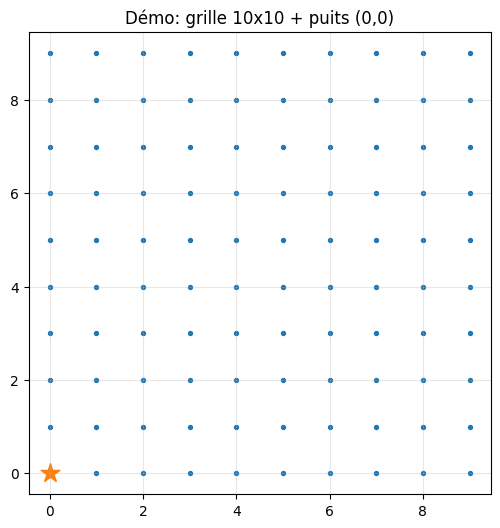

In [152]:
def plot_instance(inst, title= None):
    xy = inst.coords
    plt.figure(figsize=(6,6))
    plt.scatter(xy[:,0], xy[:,1], s=8)
    plt.scatter([inst.sink[0]], [inst.sink[1]], marker='*', s=200)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, alpha=0.3)
    plt.title(title or inst.name)
    plt.show()

inst_demo = make_grid(10, 10)
plot_instance(inst_demo, 'Démo: grille 10x10 + puits (0,0)')

## Pré-calculs : captation / communication / plus courts chemins

On pré-calcule :
- `cover[v]` = liste des cibles couvertes si on place un capteur sur la cible `v`.
- `com_adj` = liste d'adjacence du graphe de communication sur **(N cibles + 1 puits)**.
- `parent` = parents BFS depuis le puits (pour reconstruire un chemin rapide pour raccorder).


In [153]:
@dataclass
class Precomputation:
    inst: Instance
    Rcapt: float
    Rcom: float
    cover: List[np.ndarray]           # cover[v] -> indices des cibles couvertes
    com_adj: List[List[int]]          # adjacence sur N+1 noeuds (dernier = puits)
    sink_index: int                   # = N
    parent_from_sink: List[int]       # parents BFS, taille N+1

def build_precomp(inst, Rcapt, Rcom):
    assert Rcom >= Rcapt, "Rcom doit être supérieur à Rcapt"
    coords = inst.coords
    N = coords.shape[0]
    sink = np.array(inst.sink, dtype=float)
    all_coords = np.vstack([coords, sink[None, :]])  # N+1

    # Distances au carré
    # (N+1)x(N+1)
    diff = all_coords[:, None, :] - all_coords[None, :, :]
    dist2 = np.einsum('ijk,ijk->ij', diff, diff)

    Rcapt2 = Rcapt * Rcapt
    Rcom2 = Rcom * Rcom

    # Couverture: uniquement pour les cibles (pas le puits)
    cover = []
    for v in range(N):
        covered = np.where(dist2[v, :N] <= Rcapt2)[0]
        cover.append(covered.astype(int))

    # Graphe de communication sur N+1 noeuds
    com_adj = [[] for _ in range(N+1)]
    for i in range(N+1):
        neigh = np.where((dist2[i] <= Rcom2) & (np.arange(N+1) != i))[0]
        com_adj[i] = neigh.astype(int).tolist()

    sink_index = N

    # BFS depuis le puits sur le graphe complet
    parent = [-1] * (N+1)
    parent[sink_index] = sink_index
    q = deque([sink_index])
    while q:
        u = q.popleft()
        for w in com_adj[u]:
            if parent[w] == -1:
                parent[w] = u
                q.append(w)

    return Precomputation(inst=inst, Rcapt=Rcapt, Rcom=Rcom, cover=cover, com_adj=com_adj,
                   sink_index=sink_index, parent_from_sink=parent)


## Évaluation / faisabilité

In [154]:
def is_connected_to_sink(selected, pc):
    """
    Vérifie si les capteurs sélectionnés sont connectés au puits.
    """
    # selected: tableau booléen de taille N (capteurs)
    N = pc.inst.coords.shape[0]
    sink = pc.sink_index

    # noeuds actifs : capteurs + puits
    active = np.zeros(N+1, dtype=bool)
    active[:N] = selected
    active[sink] = True

    # BFS depuis le puits dans le sous-graphe induit
    seen = np.zeros(N+1, dtype=bool)
    q = deque([sink])
    seen[sink] = True
    while q:
        u = q.popleft()
        for w in pc.com_adj[u]:
            if active[w] and not seen[w]:
                seen[w] = True
                q.append(w)

    # Tous les capteurs doivent être vus
    return bool(np.all(seen[:N][selected]))

def compute_coverage_counts(selected, pc):
    """
    Calcule le nombre de fois que chaque cible est couverte par les capteurs sélectionnés.
    """
    N = pc.inst.coords.shape[0]
    cov = np.zeros(N, dtype=int)
    idx = np.where(selected)[0]
    for v in idx:
        cov[pc.cover[v]] += 1
    return cov

def is_fully_covered(selected,pc):
    """
    Vérifie si toutes les cibles sont couvertes par au moins un capteur sélectionné.
    """
    cov = compute_coverage_counts(selected, pc)
    return bool(np.all(cov > 0))
     
def is_feasible(selected, pc, debug=False):
    """il faut que tout soit couvert et connecté au puit"""
    fully_covered = is_fully_covered(selected, pc)
    connected_to_sink = is_connected_to_sink(selected, pc)
    
    if debug:
        if not fully_covered:
            print("Condition non remplie: Toutes les cibles ne sont pas couvertes.")
        if not connected_to_sink:
            print("Condition non remplie: Les capteurs ne sont pas connectés au puits.")
    
    return fully_covered and connected_to_sink

def fitness_penalized(selected, pc, lam_cov=10.0, lam_con=10.0):
    """ Calcul de la fonction objectif pénalisée.
    nb: nombre de capteurs sélectionnés
    uncovered: nombre de cibles non couvertes
    disconnected: 1 si le réseau n'est pas connecté au puits, 0 sinon
    """
    N = pc.inst.coords.shape[0]
    nb = int(selected.sum())
    cov = compute_coverage_counts(selected, pc)
    uncovered = int(np.sum(cov == 0))
    connected = is_connected_to_sink(selected, pc)
    disconnected = 0 if connected else 1
    return nb + lam_cov * uncovered + lam_con * disconnected

In [155]:
def path_to_sink(node, pc, selected_mask):
    """
    Retourne le chemin du noeud vers le puits, mais S'ARRÊTE
    dès qu'on rencontre un noeud déjà sélectionné (actif).
    """
    parent = pc.parent_from_sink
    sink = pc.sink_index
    
    # Si le noeud lui-même est déjà le puits ou sélectionné (cas limite)
    if node == sink or selected_mask[node]:
        return []

    path = [node]
    cur = node
    
    while True:
        par = parent[cur]
        
        # Cas 1: On arrive au puits (fin absolue)
        if par == sink:
            # On ajoute le puits si nécessaire, ou on s'arrête juste avant
            # Selon votre logique précédente, le puits n'est pas un capteur à placer
            break 
            
        # Cas 2: Erreur de chemin (pas de parent)
        if par == -1:
            return [] # Chemin impossible
            
        # Cas 3 : Le parent est déjà un capteur actif !
        # On n'a pas besoin d'aller plus loin, la connexion est assurée par lui.
        if selected_mask[par]:
            break
            
        # Sinon, on continue de remonter
        cur = par
        path.append(cur)
        
    return path



## Visualisation d'une solution

In [156]:
def plot_solution(selected, pc, show_links=False, max_links=3000):
    inst = pc.inst
    xy = inst.coords
    sel_idx = np.where(selected)[0]

    plt.figure(figsize=(6,6))
    plt.scatter(xy[:,0], xy[:,1], s=8, alpha=0.4, label='cibles')
    plt.scatter(xy[sel_idx,0], xy[sel_idx,1], s=18, label=f'capteurs (k={len(sel_idx)})')
    plt.scatter([inst.sink[0]], [inst.sink[1]], marker='*', s=200, label='puits')
    
    if show_links:
        # tracer quelques liens de communication entre capteurs (et vers le puits)
        N = xy.shape[0]
        sink = pc.sink_index
        all_xy = np.vstack([xy, np.array(inst.sink)[None,:]])
        active = np.zeros(N+1, dtype=bool)
        active[:N] = selected
        active[sink] = True
        links = 0
        for u in range(N+1):
            if not active[u]:
                continue
            for v in pc.com_adj[u]:
                if v <= u:
                    continue
                if active[v]:
                    plt.plot([all_xy[u,0], all_xy[v,0]], [all_xy[u,1], all_xy[v,1]], linewidth=1, alpha=0.5)
                    links += 1
                    if links >= max_links:
                        break
            if links >= max_links:
                break

    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, alpha=0.3)
    plt.title(f"{inst.name} | Rcapt={pc.Rcapt}, Rcom={pc.Rcom}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(f"Nombre de capteurs: {len(sel_idx)}")
    plt.show()

## Fonctions utilitaires (communes aux heuristiques)

In [157]:

def add_sensor(v,selected, cov, uncovered, pc):
        if selected[v]:
            return
        selected[v] = True
        for t in pc.cover[v]:
            tt = int(t)
            cov[tt] += 1
            if cov[tt] == 1:
                uncovered.discard(tt)

In [158]:



def add_path_to_sink(v, selected, cov, uncovered, pc):
    """
    Connecte v au réseau existant.
    """
    path_segment = []
    curr = v
    sink = pc.sink_index
    parent_map = pc.parent_from_sink

    while True:
        if curr == sink:
            break
        
        if selected[curr] and curr != v:
            break

        # Vérification des bornes (seulement après avoir vérifié le puits !)
        if curr < 0 or curr >= len(selected):
            return False

        path_segment.append(curr)

        par = parent_map[curr]
        if par == -1:
            return False
        
        curr = par

    # Application des ajouts
    for node in reversed(path_segment):
        add_sensor(node, selected, cov, uncovered, pc)
        
    return True



# Heuristiques 

- heuristique du plus proche voisin: select les cibles non couvertes et + proches du puits et place un capteurs sur ces cibles jusqu'à ce que toutes les cibles soient couvertes; 

- heurstique d'insertion: ajoute des capteurs de manière itérative et maximise le gain de couverture. A chaque pas on choisit la cible qui couvre le plus grand nommbre de nouvelles cibles. 

- heuristique gloutonne - profit/coût de connexion : évaluatio ndes cibles en fonction de calcul d'un score basé sur le gain de couverture/ coût de connexion au puits. On ajoute des capteurs jusqu'à ce que toutes les cibles soient couvertes. 


### heuristique du plus proche voisin 


Heuristique du plus proche voisin : 95 capteurs, faisable? True


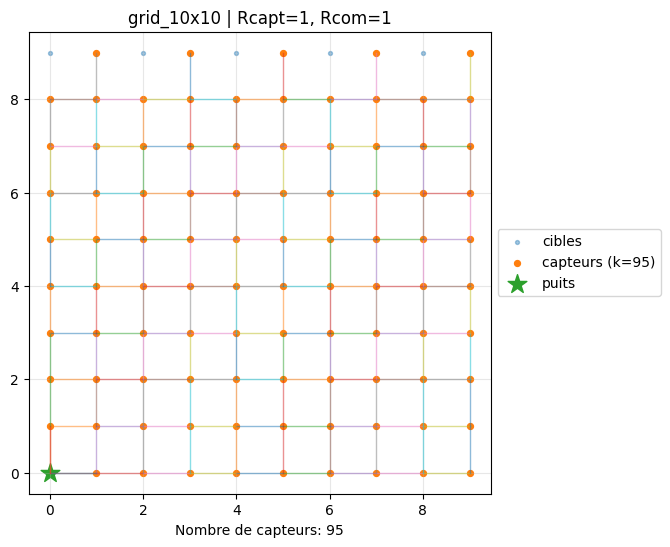

In [159]:
import numpy as np

def distance_to_sink(target, sink_coords, pc):
    return float(np.linalg.norm(pc.inst.coords[target] - sink_coords))


def nearest_neighbor_heuristic(pc):
    N = pc.inst.coords.shape[0]
    sink = pc.sink_index

    selected = np.zeros(N, dtype=bool)
    cov = np.zeros(N, dtype=int)
    uncovered = set(range(N))
    sink_coords = np.array(pc.inst.sink)
   

    while uncovered:
        nearest_target = min(uncovered, key=lambda t: distance_to_sink(t, sink_coords, pc))

        ok = add_path_to_sink(nearest_target, selected, cov, uncovered, pc)
        if not ok:
            uncovered.remove(nearest_target)
            continue

    return selected


inst = make_grid(10, 10)
pc = build_precomp(inst, Rcapt=1, Rcom=1)
sol = nearest_neighbor_heuristic(pc)
print('Heuristique du plus proche voisin :', int(sol.sum()), 'capteurs, faisable?', is_feasible(sol, pc))
plot_solution(sol, pc, show_links=True)

### heuristique d'insertion 

Heuristique d'insertion : 44 capteurs, faisable? True


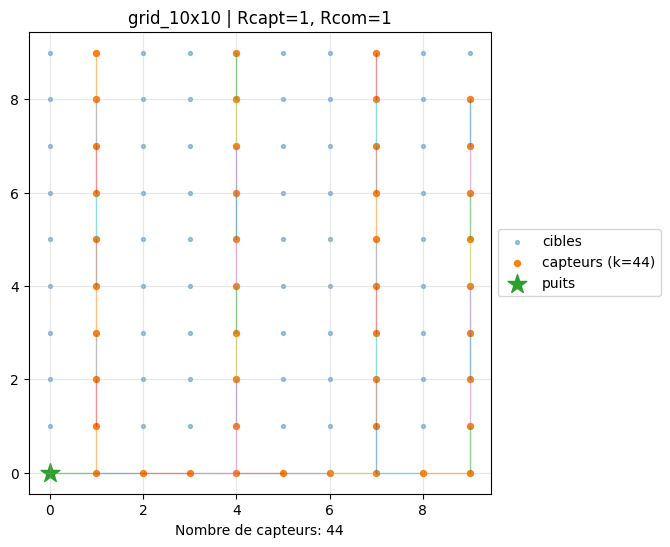

In [160]:
import numpy as np
def insertion_heuristic(pc):
    N = pc.inst.coords.shape[0]
    sink = pc.sink_index
    parent_map = pc.parent_from_sink

    selected = np.zeros(N, dtype=bool)
    cov = np.zeros(N, dtype=int)
    uncovered = set(range(N))

    # Boucle principale : tant qu'il reste des cibles à couvrir
    while uncovered:
        best_v = None
        best_score = -1.0
        
        # Optimisation : On ne stocke plus gain/added séparément si score suffit,
        # sauf pour départager les égalités (facultatif mais gardé ici pour robustesse)
        best_gain = -1
        best_added = float('inf')

        # --- Évaluation de tous les candidats ---
        for v in range(N):
            if selected[v]:
                continue
            
            # 1. Calcul rapide du Gain (cibles nouvellement couvertes)
            # On vérifie d'abord si le capteur couvre quelque chose d'utile
            gain = 0
            for t in pc.cover[v]:
                if cov[int(t)] == 0:
                    gain += 1
            
            if gain == 0:
                continue

            # 2. Calcul rapide du Coût ("added") sans créer de liste
            # On simule la remontée pour compter les capteurs à ajouter
            added = 0
            curr = v
            possible = True
            
            while True:
                if curr == sink:
                    break
                if selected[curr]: 
                    # On rejoint le réseau existant : coût additionnel nul pour le reste
                    break
                
                added += 1
                curr = parent_map[curr]
                
                if curr == -1: # Pas de chemin vers le puits
                    possible = False
                    break
            
            if not possible:
                continue

            # 3. Calcul du score
            score = gain / (1.0 + added)

            # Mise à jour du meilleur candidat
            if score > best_score:
                best_score = score
                best_v = v
                best_gain = gain
                best_added = added
            elif score == best_score:
                # Départage : on préfère celui qui couvre le plus à coût égal
                if gain > best_gain:
                    best_v = v
                    best_gain = gain
                    best_added = added

        # --- Fin de la boucle d'évaluation ---

        if best_v is None:
            # Plus aucun candidat ne peut couvrir les cibles restantes ou se connecter
            break  

        # Application du meilleur choix
        # Ici on utilise la fonction qui modifie réellement les états
        ok = add_path_to_sink(best_v, selected, cov, uncovered, pc)
        if not ok:
            # Cas rare : erreur lors de l'ajout (ne devrait pas arriver si "possible" est True)
            break

    return selected

# Test de l'heuristique par insertion
sol_insertion = insertion_heuristic(pc)
print("Heuristique d'insertion :", int(sol_insertion.sum()), "capteurs, faisable?", is_feasible(sol_insertion, pc))
plot_solution(sol_insertion, pc, show_links=True)


### Heuristique constructive (glouton profit / coût de connexion)
Dans cette heuristique, on construit une solution de manière gloutonne en évaluant les cibles selon un compromis entre le gain de couverture qu'elles apportent et le coût de connexion au puits. À chaque itération, on sélectionne la cible qui maximise un score basé sur ce compromis, puis on place un capteur sur cette cible. Ce processus est répété jusqu'à ce que toutes les cibles soient couvertes et connectées au puits.

Instance tronquée chargée avec 87 points.
Solution trouvée avec 72 capteurs.


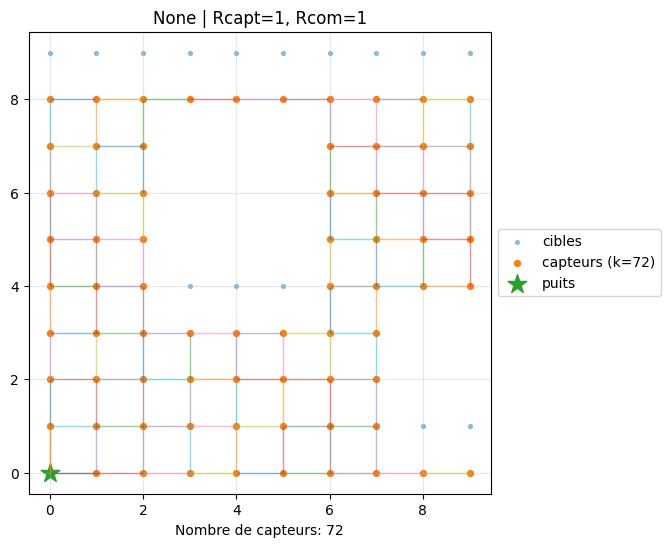

feasible? True


In [161]:
def greedy_construct(pc, max_iters=100000):
    N = pc.inst.coords.shape[0]
    selected = np.zeros(N, dtype=bool)
    cov = np.zeros(N, dtype=int)

    uncovered = set(range(N))

    it = 0
    while uncovered and it < max_iters:
        it += 1
        best_v = None
        best_score = -1.0
        best_gain = 0
        best_cost = 10**9

        # Pour accélérer, on échantillonne si N est grand
        candidates = list(uncovered)
        if len(candidates) > 600:
            candidates = random.sample(candidates, 600)

        for v in candidates:
            if selected[v]:
                continue
            covered_targets = pc.cover[v]
            gain = int(np.sum(cov[covered_targets] == 0))
            if gain == 0:
                continue

            # coût de connexion approximé: nombre de noeuds du chemin qui ne sont pas déjà sélectionnés
            p = path_to_sink(v, pc, selected)
            if not p:
                continue
            # p contient aussi le puits (index N), qu'on n'ajoute pas
            cost = 0
            for node in p:
                if node != pc.sink_index and not selected[node]:
                    selected[node] = True
                    cov[pc.cover[node]] += 1
                    for t in pc.cover[node]:
                        uncovered.discard(int(t))
                if node < N and not selected[node] and node != v:
                    cost += 1

            score = gain / (1.0 + cost)
            if score > best_score or (score == best_score and gain > best_gain) or (score == best_score and gain == best_gain and cost < best_cost):
                best_v = v
                best_score = score
                best_gain = gain
                best_cost = cost

        if best_v is None:
            # repli : prendre une cible non couverte au hasard
            best_v = next(iter(uncovered))

        # Ajouter le capteur best_v
        selected[best_v] = True
        cov[pc.cover[best_v]] += 1
        for t in pc.cover[best_v]:
            uncovered.discard(int(t))

        # Option : si best_v est loin du puits, ajouter aussi les relais pour faciliter la suite
        p = path_to_sink(best_v, pc, selected)
        for node in p:
            if node < N and not selected[node]:
                selected[node] = True
                cov[pc.cover[node]] += 1
                for t in pc.cover[node]:
                    uncovered.discard(int(t))

    return selected

# Exemple d'utilisation
#inst = make_grid(10, 10, sink=(0.0, 0.0), name="grille20x20")
inst = load_points_txt("C:/Users/Charlène/Documents/ENSTA/3A/Metaheuristique/Projet/Projet de métaheuristiques - Instances grilles tronquées/Projet de métaheuristiques - Instances grilles tronquées/grille1010_1.dat", truncated=True)
pc = build_precomp(inst, Rcapt=1, Rcom=1)
sol = greedy_construct(pc)
print(f"Solution trouvée avec {int(sol.sum())} capteurs.")
plot_solution(sol, pc, show_links=True)
print(f"feasible? {is_feasible(sol, pc)}")

## Réparation (couverture + connexité)

Après perturbation (ou permutation), la solution peut devenir infaisable :
- la couverture,
- la connexité.

Réparation = (1) réparer la couverture (glouton max gain) (2) relier au puits en ajoutant des relais sur des plus courts chemins.

Ensuite on élague.

In [162]:
def repair_coverage(selected, pc):
    """
    Répare la couverture en ajoutant des capteurs de manière gloutonne.
    À chaque itération, on sélectionne la cible non couverte qui maximise
    le gain de couverture (nombre de nouvelles cibles couvertes) et on
    place un capteur sur cette cible. Ce processus est répété jusqu'à ce
    que toutes les cibles soient couvertes.
    """
    N = pc.inst.coords.shape[0]
    sel = selected.copy()
    cov = compute_coverage_counts(sel, pc)

    uncovered = np.where(cov == 0)[0]
    uncovered_set = set(uncovered.tolist())

    while uncovered_set:
        best_v, best_gain = None, -1

        candidates = list(uncovered_set)
        if len(candidates) > 600:
            candidates = random.sample(candidates, 600)

        for v in candidates:
            if sel[v]:
                continue
            gain = 0
            for t in pc.cover[v]:
                if int(t) in uncovered_set:
                    gain += 1
            if gain > best_gain:
                best_gain = gain
                best_v = v

        if best_v is None:
            best_v = next(iter(uncovered_set))

        sel[best_v] = True
        cov[pc.cover[best_v]] += 1
        for t in pc.cover[best_v]:
            uncovered_set.discard(int(t))

    return sel

def repair_connectivity(selected: np.ndarray, pc: Precomputation) -> np.ndarray:
    """
    Répare la connectivité en ajoutant des relais pour connecter les capteurs au puits.
    À chaque itération, on vérifie si les capteurs sélectionnés sont connectés au puits.
    Si ce n'est pas le cas, on ajoute les relais nécessaires pour établir la connexion.
    Ce processus est répété jusqu'à ce que tous les capteurs soient connectés ou qu'un
    nombre maximal de passes soit atteint.
    """
    N = pc.inst.coords.shape[0]
    sel = selected.copy()

    # Si déjà connecté, rien à faire
    if is_connected_to_sink(sel, pc):
        return sel

    # Stratégie simple: pour chaque capteur non connecté, ajouter son chemin vers le puits
    # (on fait quelques passes, car ajouter des relais peut connecter plein de monde)
    for _ in range(3):
        if is_connected_to_sink(sel, pc):
            break
        idx = np.where(sel)[0]
        random.shuffle(idx.tolist())
        for v in idx:
            # si v n'est pas connectable via le parent (cas rare si graphe global connexe), on ignore
            p = path_to_sink(int(v), pc, sel)
            for node in p:
                if node < N:
                    sel[node] = True
    return sel


## Élagage : supprimer des capteurs inutiles

On enlève des capteurs tant que :
- la couverture reste complète,
- le graphe reste connecté au puits.

On le fait en boucle jusqu'à stabilisation.

In [163]:
def prune_redundant(selected, pc, max_passes=5):
    """
    Élaguer les capteurs redondants de la sélection tout en maintenant la faisabilité.
    Cette fonction supprime de manière itérative les capteurs qui contribuent le moins
    à la couverture et à la connectivité, en veillant à ce que la solution reste faisable
    (complètement couverte et connectée au puits).

    Args:
        selected: Un tableau booléen indiquant les capteurs sélectionnés.
        pc: Les données pré-calculées pour l'instance.
        max_passes: Le nombre maximal de passes d'élagage.

    Returns:
        Le tableau de sélection élagué.
    """
    N = pc.inst.coords.shape[0]
    sel = selected.copy()

    for _ in range(max_passes):
        changed = False
        cov = compute_coverage_counts(sel, pc)

        # Heuristique d'ordre : enlever d'abord ceux qui couvrent peu
        idx = np.where(sel)[0]
        contrib = []
        for v in idx:
            # contribution = nb de cibles pour lesquelles v est le seul couvreur
            c = 0
            for t in pc.cover[int(v)]:
                if cov[int(t)] == 1:
                    c += 1
            contrib.append((c, int(v)))
        contrib.sort()  # enlever d'abord petite contribution

        for _, v in contrib:
            # tentative suppression
            sel[v] = False
            # test couverture rapide
            ok_cov = True
            for t in pc.cover[v]:
                if cov[int(t)] == 1:
                    ok_cov = False
                    break
            if ok_cov and is_connected_to_sink(sel, pc):
                # suppression acceptée => mettre à jour cov
                cov[pc.cover[v]] -= 1
                changed = True
            else:
                sel[v] = True

        if not changed:
            break

    return sel

def repair(selected,pc):
    """
    Répare une solution en trois étapes :
    1. Réparer la couverture en ajoutant des capteurs pour couvrir toutes les cibles.
    2. Réparer la connectivité en ajoutant des relais pour connecter tous les capteurs au puits.
    3. Élaguer les capteurs redondants tout en maintenant la faisabilité (couverture et connexité).
    """
    sel = repair_coverage(selected, pc)
    sel = repair_connectivity(sel, pc)
    # Une fois connecté, on élague
    sel = prune_redundant(sel, pc)
    return sel

# Recherche locale : Voisinage 

- local swap -> permet pas d'améliorer la fonction objectif mais permet d'explorer d'autres config

In [164]:
def local_search_swaps(selected, pc, trials=500):
    N = pc.inst.coords.shape[0]
    best = prune_redundant(selected, pc)
    best_k = int(best.sum())

    sel_idx = np.where(best)[0].tolist()
    non_idx = np.where(~best)[0].tolist()
    if not sel_idx or not non_idx:
        return best

    for _ in range(trials):
        a = random.choice(sel_idx)
        b = random.choice(non_idx)
        cand = best.copy()
        cand[a] = False
        cand[b] = True
        # Réparation pour rester faisable
        cand = repair(cand, pc)
        cand_k = int(cand.sum())
        if cand_k < best_k:
            best, best_k = cand, cand_k
            sel_idx = np.where(best)[0].tolist()
            non_idx = np.where(~best)[0].tolist()
            if not sel_idx or not non_idx:
                break

    return best

### Fusionner 2 capteurs en 1

On parcourt tous les couples de capteurs et on voit si on améliore ou pas

In [165]:
import numpy as np

def merge_2_en_1(
    selected,
    pc,
    eps=1e-9,
    max_steps=100_000
):
    sel = selected.astype(bool).copy()
    coords = pc.inst.coords

    steps = 0
    while steps < max_steps:
        sel_idx = np.where(sel)[0]
        if len(sel_idx) <= 1:
            break

        best_new_sel = None
        best_score = float('inf')  # plus petit = meilleur

        # scan complet de tous les couples
        for ii in range(len(sel_idx)):
            a = int(sel_idx[ii])
            for jj in range(ii + 1, len(sel_idx)):
                b = int(sel_idx[jj])

                midpoint = (coords[a] + coords[b]) / 2.0
                d = np.linalg.norm(coords - midpoint, axis=1)
                c = int(np.argmin(d))

                # STRICT : le milieu doit être exactement une cible
                if d[c] > eps:
                    continue

                new_sel = sel.copy()
                new_sel[a] = False
                new_sel[b] = False
                new_sel[c] = True

                # doit réduire + rester admissible
                if new_sel.sum() >= sel.sum():
                    continue
                if not is_feasible(new_sel, pc):
                    continue

                # critère de départage (modifiable)
                score = np.linalg.norm(coords[a] - coords[b])  # fusionner les plus proches

                if best_new_sel is None or score < best_score:
                    best_new_sel = new_sel
                    best_score = score

        # aucune fusion admissible => plus d'amélioration
        if best_new_sel is None:
            break

        sel = best_new_sel
        steps += 1

    return sel


### merge n en 1 

- on cherche barycentre des polygone si on tombe sur une cible OK 
- Check si encore faisable 
- on applique la modif optimale
- reitère jusqu'a plus de fusion possible ou qu'il ne reste qu'un seul capteur 

Solution initiale (heuristique simple): 76 capteurs, faisable? True
Après fusion n-uplet -> 1: 43 capteurs, faisable? True


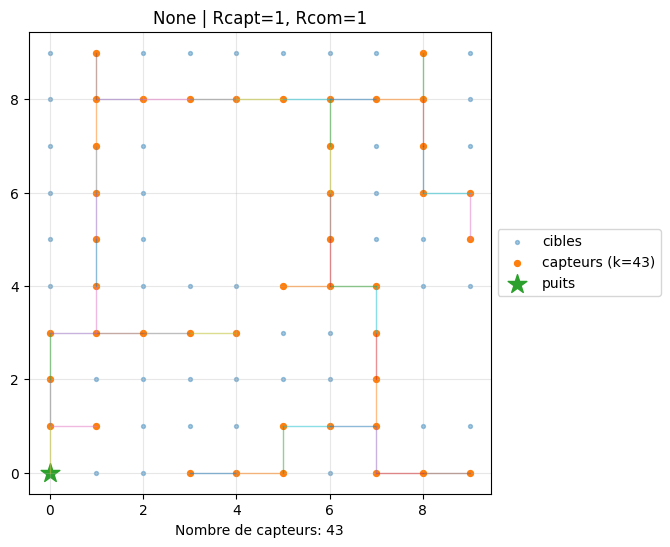

In [166]:
import numpy as np
from itertools import combinations

def merge_sensors_to_1(
    selected: np.ndarray,
    pc: "Precomputation",
    eps: float = 1e-9,
    max_tuple_size: int | None = None,
    max_steps: int = 100_000,
):
    """
    Fusion k->1 (k-uplets): le barycentre doit coïncider (à eps près) avec une cible existante.
    Best-improvement :
      - on scanne tous les k-uplets (k = 2..K) de capteurs actifs
      - on garde les fusions admissibles (is_feasible)
      - on choisit celle qui réduit le plus (gain = k-1), tie-break: tuple le plus compact
      - on applique et on recommence jusqu'à atteindre 1 capteur ou blocage

    Retour : (sel_final: np.ndarray[bool], reached_one: bool)
    """
    sel = selected.astype(bool).copy()
    coords = pc.inst.coords

    steps = 0
    while sel.sum() > 1 and steps < max_steps:
        sel_idx = np.where(sel)[0]
        n = int(sel_idx.size)
        if n <= 1:
            break

        K = n if max_tuple_size is None else min(int(max_tuple_size), n)

        best_new_sel = None
        best_gain = -1
        best_score = float("inf")  # plus petit = meilleur (compacité)

        # gros k d'abord => permet de trouver rapidement de gros gains,
        # mais on garde quand même le "best improvement" global via best_gain/best_score
        for k in range(K, 1, -1):
            for tup in combinations(sel_idx, k):
                tup = np.fromiter(tup, dtype=int, count=k)

                center = coords[tup].mean(axis=0)

                d = np.linalg.norm(coords - center, axis=1)
                c = int(np.argmin(d))

                # STRICT: barycentre doit être sur une cible existante
                if d[c] > eps:
                    continue

                new_sel = sel.copy()
                new_sel[tup] = False
                new_sel[c] = True  # c peut être dans tup, c'est ok

                # doit réduire strictement le nombre de capteurs
                if new_sel.sum() >= sel.sum():
                    continue

                if not is_feasible(new_sel, pc):
                    continue

                gain = k - 1
                score = float(np.sum(np.linalg.norm(coords[tup] - center, axis=1)))

                # best improvement + tie-break compacité
                if (gain > best_gain) or (gain == best_gain and score < best_score):
                    best_new_sel = new_sel
                    best_gain = gain
                    best_score = score

        if best_new_sel is None:
            break

        sel = best_new_sel
        steps += 1

    return sel

# Exemple d'utilisation avec une heuristique simple suivie de la fusion n-uplet -> 1
sol_simple = nearest_neighbor_heuristic(pc)
print("Solution initiale (heuristique simple):", int(sol_simple.sum()), "capteurs, faisable?", is_feasible(sol_simple, pc))

sol_merged = merge_sensors_to_1(sol_simple, pc, max_tuple_size=4)
print("Après fusion n-uplet -> 1:", int(sol_merged.sum()), "capteurs, faisable?", is_feasible(sol_merged, pc))

plot_solution(sol_merged, pc, show_links=True)

# Meta-heuristiques basée sur une seule solution 

- VNS 
- VND
- GRASP

### VNS (Recherche à voisinage variable)

On utilise le schéma classique :
- solution initiale (glouton)
- pour `k = 1..kmax` :
  - *secousse* : enlever `k` capteurs au hasard
  - réparation (couverture + connexité) + élagage
  - (option) recherche locale (permutations)
  - si amélioration : on accepte et on revient à `k=1`, sinon on incrémente `k`

Ça correspond exactement à l'idée "plusieurs voisinages" vue en cours (Vk = k transformations).

In [167]:
def shake_k_remove(selected,k):
    sel = selected.copy()
    idx = np.where(sel)[0].tolist()
    if not idx:
        return sel
    k = min(k, len(idx))
    rem = random.sample(idx, k)
    sel[rem] = False
    return sel

def vns(pc, kmax=8, iters=60, do_swaps=True):
    # Solution initiale
    cur = greedy_construct(pc)
    cur = repair(cur, pc)
    cur_k = int(cur.sum())
    best = cur.copy()
    best_k = cur_k

    for _ in range(iters):
        k = 1
        improved = False
        while k <= kmax:
            cand = shake_k_remove(cur, k)
            cand = repair(cand, pc)
            if do_swaps:
                cand = local_search_swaps(cand, pc, trials=200)
            cand_k = int(cand.sum())

            if cand_k < cur_k:
                cur, cur_k = cand, cand_k
                improved = True
                k = 1
            else:
                k += 1

            if cur_k < best_k:
                best, best_k = cur.copy(), cur_k

        # si aucune amélioration sur ce cycle, on fait une mini-perturbation pour diversifier
        if not improved:
            cur = shake_k_remove(best, max(1, kmax//2))
            cur = repair(cur, pc)
            cur_k = int(cur.sum())

    return best

## VND - Descente de voisinage variables 

- 1 sol faisable
-  exploration des voisinages 
- so meilleure sol on met à jour la sol courante
- on s'arrête si on a tout exploré



VNS: Solution trouvée avec 15 capteurs.


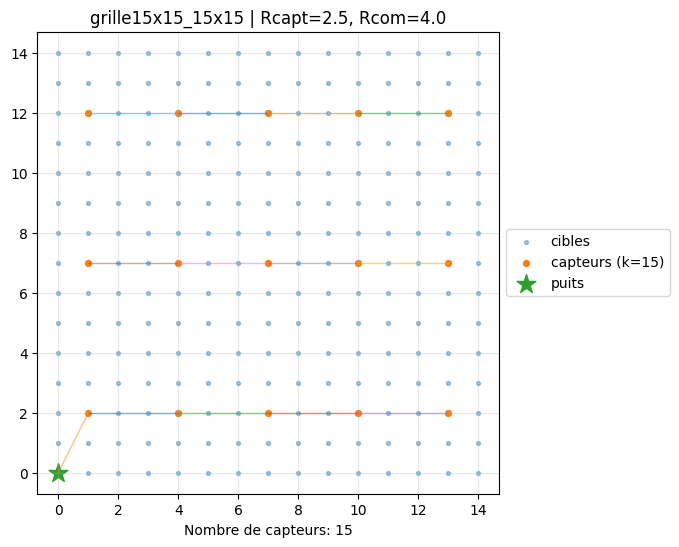

VND: Solution trouvée avec 15 capteurs.


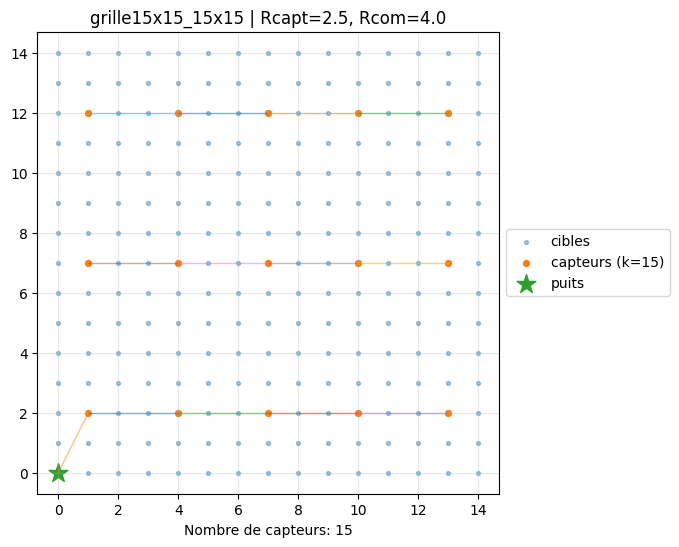

In [168]:
def vnd(selected, pc, max_neighborhood=3, max_trials=500):
    """
    Algorithme de Descente à Voisinage Variable (VND).
    Explore plusieurs voisinages pour améliorer itérativement la solution.

    Args:
        selected: Solution initiale.
        pc: Données pré-calculées pour l'instance.
        max_neighborhood: Nombre maximal de voisinages à explorer.
        max_trials: Nombre maximal d'essais pour la recherche locale dans chaque voisinage.

    Returns:
        Solution améliorée.
    """
    cur = prune_redundant(selected, pc)  # Élaguer les capteurs redondants
    cur_k = int(cur.sum())
    best = cur.copy()
    best_k = cur_k

    neighborhood = 1
    while neighborhood <= max_neighborhood:
        if neighborhood == 1:
            # Recherche locale avec permutations
            cand = local_search_swaps(cur, pc, trials=max_trials)
        elif neighborhood == 2:
            # Fusion 2 -> 1
            cand = merge_2_en_1(cur, pc)
        elif neighborhood == 3:
            # Fusion n -> 1 avec des petits groupes
            cand = merge_sensors_to_1(cur, pc, max_tuple_size=3)
        else:
            break

        cand_k = int(cand.sum())
        if cand_k < cur_k:
            cur, cur_k = cand, cand_k
            neighborhood = 1  # Repartir du premier voisinage
        else:
            neighborhood += 1  # Passer au voisinage suivant

        if cur_k < best_k:
            best, best_k = cur.copy(), cur_k

    return best


# Exemple d'utilisation de VNS et VND
inst = make_grid(15, 15, sink=(0.0, 0.0), name="grille15x15")
pc = build_precomp(inst, Rcapt=2.5, Rcom=4.0)
sol_vns = vns(pc, kmax=6, iters=30, do_swaps=True)
print(f"VNS: Solution trouvée avec {int(sol_vns.sum())} capteurs.")
plot_solution(sol_vns, pc, show_links=True) 
sol_vnd = vnd(sol_vns, pc, max_neighborhood=3, max_trials=300)
print(f"VND: Solution trouvée avec {int(sol_vnd.sum())} capteurs.")
plot_solution(sol_vnd, pc, show_links=True)

GRASP: Solution trouvée avec 17 capteurs, faisable? True


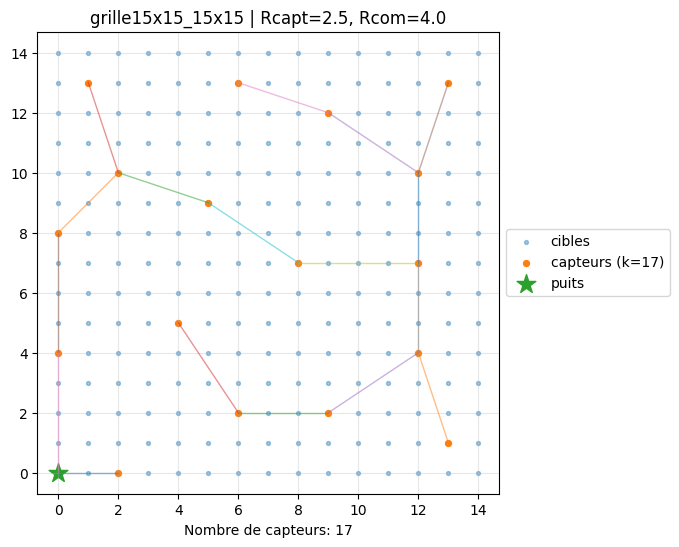

In [169]:
def grasp(pc, max_iters=100, alpha=0.2, local_search_trials=500):
    """
    Implémente la méthode GRASP (Greedy Randomized Adaptive Search Procedure).
    
    Args:
        pc: Les données pré-calculées pour l'instance.
        max_iters: Nombre maximal d'itérations.
        alpha: Paramètre de contrôle pour la phase constructive (0 = purement glouton, 1 = purement aléatoire).
        local_search_trials: Nombre d'essais pour la recherche locale.

    """
    best_solution = None
    best_fitness = float('inf')

    for _ in range(max_iters):
        # Phase constructive
        solution = nearest_neighbor_heuristic(pc)

        # Phase de recherche locale
        solution = local_search_swaps(solution, pc, trials=local_search_trials)

        # Évaluer la solution
        solution_fitness = fitness_penalized(solution, pc)

        # Mettre à jour la meilleure solution
        if solution_fitness < best_fitness:
            best_solution = solution
            best_fitness = solution_fitness

    return best_solution

# Exemple d'utilisation
inst = make_grid(15, 15, sink=(0.0, 0.0), name="grille15x15")
pc = build_precomp(inst, Rcapt=2.5, Rcom=4.0)
sol_grasp = grasp(pc, max_iters=50, alpha=0.3, local_search_trials=300)
print(f"GRASP: Solution trouvée avec {int(sol_grasp.sum())} capteurs, faisable? {is_feasible(sol_grasp, pc)}")
plot_solution(sol_grasp, pc, show_links=True)

# Meta heuristique basée sur une famille de solutions 

- algo génétique 
- exploration de grand voisinage


### Algo génétique 

L'initialisation doit être diversifié c'est pourquoi l'on definit une fonction qui tirera au sort parmi les meilleurs solutions trouvées 

In [172]:
def randomized_nearest_neighbor_heuristic(pc, alpha=0.2):
    """
    Heuristique constructive aléatoire.
    alpha = 0.0 : Glouton pur (toujours la cible la plus proche du puits).
    alpha = 1.0 : Aléatoire pur (n'importe quelle cible non couverte).
    """
    N = pc.inst.coords.shape[0]
    sink = pc.sink_index

    selected = np.zeros(N, dtype=bool)
    cov = np.zeros(N, dtype=int)
    uncovered = set(range(N))
    sink_coords = np.array(pc.inst.sink)
  
    while uncovered:
        # 1. Calculer les distances pour toutes les cibles restantes
        # On crée une liste de tuples (cible, distance)
        candidates = []
        for t in uncovered:
            dist = distance_to_sink(t, sink_coords, pc)
            candidates.append((t, dist))
        
        # 2. Si un seul candidat, pas besoin de trier
        if len(candidates) == 1:
            chosen_target = candidates[0][0]
        
        else:
            # 3. Trouver min et max pour définir le seuil RCL
            candidates.sort(key=lambda x: x[1]) # Tri par distance croissante
            
            min_dist = candidates[0][1]
            max_dist = candidates[-1][1]
            
            # on accepte tout ce qui est <= min + alpha * (écart)
            threshold = min_dist + alpha * (max_dist - min_dist)
            
            # 4. Construire la Restricted Candidate List (RCL)
            # Comme la liste est triée, on peut juste prendre les éléments jusqu'au seuil
            rcl = []
            for cand in candidates:
                if cand[1] <= threshold:
                    rcl.append(cand[0])
                else:
                    # Dès qu'on dépasse le seuil, on arrête 
                    break
            
            # 5. Choix aléatoire dans la RCL
            chosen_target = random.choice(rcl)


        ok = add_path_to_sink(chosen_target, selected, cov, uncovered, pc)
        if not ok:
            # Si impossible de relier cette cible, on l'enlève des candidats pour la suite
            uncovered.remove(chosen_target)
            continue

    return selected

In [173]:
def genetic_algorithm(pc, population_size=50, generations=100, mutation_rate=0.1, alpha = 0.3):


    def initialize_population():
        population = []
    
        for _ in range(population_size):
            # phase Constructive Randomisée 
            individual = randomized_nearest_neighbor_heuristic(pc, alpha=alpha) 
        
            #recherche Locale 
            individual = local_search_swaps(individual, pc, trials=50) 
        
            population.append(individual)
        
        return population
    

    def fitness(individual):
        return fitness_penalized(individual, pc)

    def select_parents(population):
        # Sélection par tournoi
        tournament_size = 5
        selected = []
        for _ in range(2):
            tournament = random.sample(population, tournament_size)
            best = min(tournament, key=fitness)
            selected.append(best)
        return selected

    def crossover(parent1, parent2):
        # Croisement à un point
        point = random.randint(1, len(parent1) - 1)
        child = np.concatenate((parent1[:point], parent2[point:]))
        return child

    def mutate(individual):
        # Mutation aléatoire
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = not individual[i]
        return individual

    def repair_population(population):
        return [repair(ind, pc) for ind in population]

    # Initialisation
    population = initialize_population()
    population = repair_population(population)
    

    # verif diversité initiale  
    population_set = {tuple(ind) for ind in population}
    nb_unique = len(population_set)

    print(f"Taille de la population = {len(population)}")
    print(f"Nombre d'individus uniques = {nb_unique}")
    if nb_unique == 1:
        print("ATTENTION : Tous les individus sont identiques ! L'algo génétique ne convergera pas bien.")
    else:
        print(f"Diversité initiale : {nb_unique/len(population)*100:.1f}%")
# ------------------------------------

    best_solution = min(population, key=fitness)
    best_fitness = fitness(best_solution)

    for generation in range(generations):
        new_population = []

        # Générer une nouvelle population
        while len(new_population) < population_size:
            parent1, parent2 = select_parents(population)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        # Réparer les individus et mettre à jour la population
        new_population = repair_population(new_population)
        population = new_population

        # Mettre à jour la meilleure solution
        current_best = min(population, key=fitness)
        current_fitness = fitness(current_best)
        if current_fitness < best_fitness:
            best_solution, best_fitness = current_best, current_fitness

        #print(f"Génération {generation + 1}: Meilleure fitness = {best_fitness}, Capteurs = {int(best_solution.sum())}")

    return best_solution

# Exemple d'utilisation
inst = make_grid(15, 15, sink=(0.0, 0.0), name="grille15x15")
pc = build_precomp(inst, Rcapt=2.5, Rcom=4.0)
sol_ga = genetic_algorithm(pc, population_size=30, generations=50, mutation_rate=0.05, alpha=0.2)
print(f"Algorithme génétique: Solution trouvée avec {int(sol_ga.sum())} capteurs, faisable? {is_feasible(sol_ga, pc)}")


Taille de la population = 30
Nombre d'individus uniques = 30
Diversité initiale : 100.0%
Algorithme génétique: Solution trouvée avec 16 capteurs, faisable? True


# APPLICATION 


In [174]:
import time

# # Fonction pour mesurer le temps et la qualité de la solution
def evaluate_algorithm(algorithm, *args, **kwargs):
    start_time = time.time()
    solution = algorithm(*args, **kwargs)
    elapsed_time = time.time() - start_time
    solution_size = int(solution.sum())
    feasible = is_feasible(solution, pc)
    return elapsed_time, solution_size, feasible

# results = []

# # Baselines
# results.append(("Greedy Construct", *evaluate_algorithm(greedy_construct, pc)))
# results.append(("Nearest Neighbor", *evaluate_algorithm(nearest_neighbor_heuristic, pc)))
# results.append(("Insertion Heuristic", *evaluate_algorithm(insertion_heuristic, pc)))

# # Point de départ faisable pour les méthodes "amélioration"
# sol_base = greedy_construct(pc)
# sol_base = repair(sol_base, pc)
# sol_base = prune_redundant(sol_base, pc)  # optionnel mais souvent utile

# results.append(("Greedy + Repair", *evaluate_algorithm(lambda s, pc: repair(s, pc), greedy_construct(pc), pc)))

# # Merge 2 -> 1 et Merge n -> 1 (sur sol_base)
# results.append(("Merge 2 -> 1", *evaluate_algorithm(merge_2_en_1, sol_base, pc)))
# results.append(("Merge n -> 1", *evaluate_algorithm(merge_sensors_to_1, sol_base, pc, max_tuple_size=3)))

# # VNS
# results.append(("VNS", *evaluate_algorithm(vns, pc, kmax=8, iters=40, do_swaps=True)))
# # VND
# results.append(("VND", *evaluate_algorithm(vnd, sol_base, pc, max_neighborhood=3, max_trials=300)))

# # GRASP
# results.append(("GRASP", *evaluate_algorithm(grasp, pc, max_iters=50, alpha=0.3, local_search_trials=300)))

# # Genetic Algorithm
# results.append(("Genetic Algorithm", *evaluate_algorithm(genetic_algorithm, pc, population_size=50, generations=100, mutation_rate=0.1)))

# # Affichage
# print(f"{'Algorithm':<25}{'Time (s)':<10}{'Solution Size':<15}{'Feasible':<10}")
# print("-" * 60)
# for name, time_taken, size, feasible in results:
#    print(f"{name:<25}{time_taken:<10.4f}{size:<15}{feasible}")


In [183]:
import os

# TEST SUR LES INSTANCES DONNEES 

path = "C:\\Users\\Charlène\\Documents\\ENSTA\\3A\\Metaheuristique\\Projet\\Projet de métaheuristiques - Instances grilles tronquées\\Projet de métaheuristiques - Instances grilles tronquées"

# Parcourir tous les fichiers dans le répertoire donné
for filename in os.listdir(path):
    print(filename)
    if filename.endswith(".dat"):
        filepath = os.path.join(path, filename)
        print(f"Testing on instance: {filename}")

        # Charger l'instance
        instance = load_points_txt(filepath, sink=(0.0, 0.0), name=filename, truncated=True)

        # Construire les pré-calculs
        pc = build_precomp(instance, Rcapt=1.0, Rcom=1.0)

        # Tester les algorithmes
        results = []
        print("Greedy Construction")
        results.append(("Greedy Construct", *evaluate_algorithm(greedy_construct, pc)))
        print("Nearest Neighbor Heuristic")
        results.append(("Nearest Neighbor", *evaluate_algorithm(nearest_neighbor_heuristic, pc)))
        print("Insertion Heuristic")
        results.append(("Insertion Heuristic", *evaluate_algorithm(insertion_heuristic, pc)))

        # Point de départ faisable pour les méthodes "amélioration"
        sol_base = greedy_construct(pc)
        sol_base = repair(sol_base, pc)
        sol_base = prune_redundant(sol_base, pc)
        print("Greedy + Repair")
        results.append(("Greedy + Repair", *evaluate_algorithm(lambda s, pc: repair(s, pc), greedy_construct(pc), pc)))

        # Merge 2 -> 1 et Merge n -> 1 (sur sol_base)
        print("Merge 2 -> 1")
        results.append(("Merge 2 -> 1", *evaluate_algorithm(merge_2_en_1, sol_base, pc)))
        print("Merge n -> 1")
        results.append(("Merge n -> 1", *evaluate_algorithm(merge_sensors_to_1, sol_base, pc, max_tuple_size=3)))

        # VNS
        #results.append(("VNS", *evaluate_algorithm(vns, pc, kmax=8, iters=40, do_swaps=True)))

        # VND
        print("VND")
        results.append(("VND", *evaluate_algorithm(vnd, sol_base, pc, max_neighborhood=3, max_trials=300)))

        # GRASP
        print("GRASP")
        results.append(("GRASP", *evaluate_algorithm(grasp, pc, max_iters=50, alpha=0.3, local_search_trials=300)))

        # Genetic Algorithm
        results.append(("Genetic Algorithm", *evaluate_algorithm(genetic_algorithm, pc, population_size=50, generations=100, mutation_rate=0.1)))

        # Afficher les résultats pour l'instance actuelle
        print(f"{'Algorithm':<25}{'Time (s)':<10}{'Solution Size':<15}{'Feasible':<10}")
        print("-" * 60)
        for name, time_taken, size, feasible in results:
            print(f"{name:<25}{time_taken:<10.4f}{size:<15}{feasible}")
        print("\n")



grille1010_1.dat
Testing on instance: grille1010_1.dat
Instance tronquée chargée avec 87 points.
Greedy Construction
Nearest Neighbor Heuristic
Insertion Heuristic
Greedy + Repair
Merge 2 -> 1
Merge n -> 1
VND
GRASP
Taille de la population = 50
Nombre d'individus uniques = 50
Diversité initiale : 100.0%
Algorithm                Time (s)  Solution Size  Feasible  
------------------------------------------------------------
Greedy Construct         0.0036    72             True
Nearest Neighbor         0.0054    76             True
Insertion Heuristic      0.0051    48             True
Greedy + Repair          0.0022    40             True
Merge 2 -> 1             0.0311    40             True
Merge n -> 1             0.3704    40             True
VND                      0.7180    40             True
GRASP                    14.6185   39             True
Genetic Algorithm        19.1306   40             True


grille1010_2.dat
Testing on instance: grille1010_2.dat
Instance tronquée cha

KeyboardInterrupt: 

## Instances non tronquées

In [184]:
import os

# TEST SUR LES INSTANCES DONNEES 

path = "C:/Users/Charlène/Documents/ENSTA/3A/Metaheuristique/Projet/Projet de métaheuristiques - Instances cibles générées aléatoirement/Projet de métaheuristiques - Instances cibles générées aléatoirement"

# Parcourir tous les fichiers dans le répertoire donné
for filename in os.listdir(path):
    print(filename)
    if filename.endswith(".dat"):
        filepath = os.path.join(path, filename)
        print(f"Testing on instance: {filename}")

        # Charger l'instance
        instance = load_points_txt(filepath, sink=(0.0, 0.0), name=filename, truncated=False)

        # Construire les pré-calculs
        pc = build_precomp(instance, Rcapt=1.0, Rcom=1.0)

        # Tester les algorithmes
        results = []
        print("Greedy Construction")
        results.append(("Greedy Construct", *evaluate_algorithm(greedy_construct, pc)))
        print("Nearest Neighbor Heuristic")
        results.append(("Nearest Neighbor", *evaluate_algorithm(nearest_neighbor_heuristic, pc)))
        print("Insertion Heuristic")
        results.append(("Insertion Heuristic", *evaluate_algorithm(insertion_heuristic, pc)))

        # Point de départ faisable pour les méthodes "amélioration"
        sol_base = greedy_construct(pc)
        sol_base = repair(sol_base, pc)
        sol_base = prune_redundant(sol_base, pc)
        print("Greedy + Repair")
        results.append(("Greedy + Repair", *evaluate_algorithm(lambda s, pc: repair(s, pc), greedy_construct(pc), pc)))

        # Merge 2 -> 1 et Merge n -> 1 (sur sol_base)
        print("Merge 2 -> 1")
        results.append(("Merge 2 -> 1", *evaluate_algorithm(merge_2_en_1, sol_base, pc)))
        #print("Merge n -> 1")
        #results.append(("Merge n -> 1", *evaluate_algorithm(merge_sensors_to_1, sol_base, pc, max_tuple_size=3)))

        # VNS
        #results.append(("VNS", *evaluate_algorithm(vns, pc, kmax=8, iters=40, do_swaps=True)))

        # VND
        print("VND")
        results.append(("VND", *evaluate_algorithm(vnd, sol_base, pc, max_neighborhood=3, max_trials=300)))

        # GRASP
        print("GRASP")
        results.append(("GRASP", *evaluate_algorithm(grasp, pc, max_iters=50, alpha=0.3, local_search_trials=300)))

        # Genetic Algorithm
        print("Genetic Algorithm")
        results.append(("Genetic Algorithm", *evaluate_algorithm(genetic_algorithm, pc, population_size=50, generations=100, mutation_rate=0.1)))

        # Afficher les résultats pour l'instance actuelle
        print(f"{'Algorithm':<25}{'Time (s)':<10}{'Solution Size':<15}{'Feasible':<10}")
        print("-" * 60)
        for name, time_taken, size, feasible in results:
            print(f"{name:<25}{time_taken:<10.4f}{size:<15}{feasible}")
        print("\n")



captANOR150_7_4.dat
Testing on instance: captANOR150_7_4.dat
Greedy Construction
Nearest Neighbor Heuristic
Insertion Heuristic
Greedy + Repair
Merge 2 -> 1
Merge n -> 1
VND
GRASP
Genetic Algorithm
Taille de la population = 50
Nombre d'individus uniques = 50
Diversité initiale : 100.0%
Algorithm                Time (s)  Solution Size  Feasible  
------------------------------------------------------------
Greedy Construct         0.0021    63             True
Nearest Neighbor         0.0120    66             True
Insertion Heuristic      0.0000    42             True
Greedy + Repair          0.0033    39             True
Merge 2 -> 1             0.0083    39             True
Merge n -> 1             0.2289    39             True
VND                      0.9180    37             True
GRASP                    30.3595   35             True
Genetic Algorithm        42.4247   35             True


captANOR1600_16_100_2021.dat
Testing on instance: captANOR1600_16_100_2021.dat
Greedy Construc

KeyboardInterrupt: 

Pour une instance, trouver la solution à l'aide de chaque algo et le plot 

Instance tronquée chargée avec 87 points.


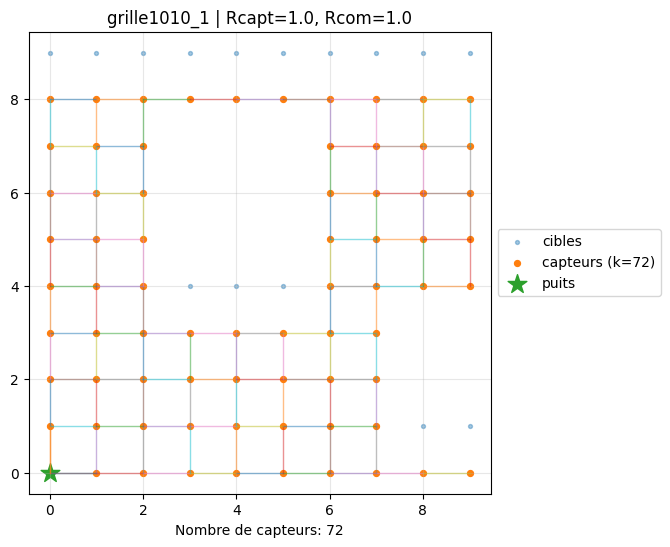

Greedy: Solution trouvée avec 72 capteurs, faisable? True


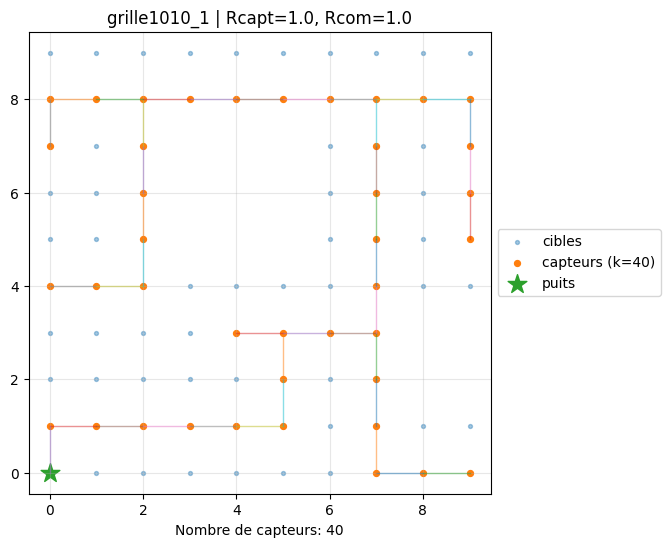

Greedy + Repair: Solution trouvée avec 40 capteurs, faisable? True


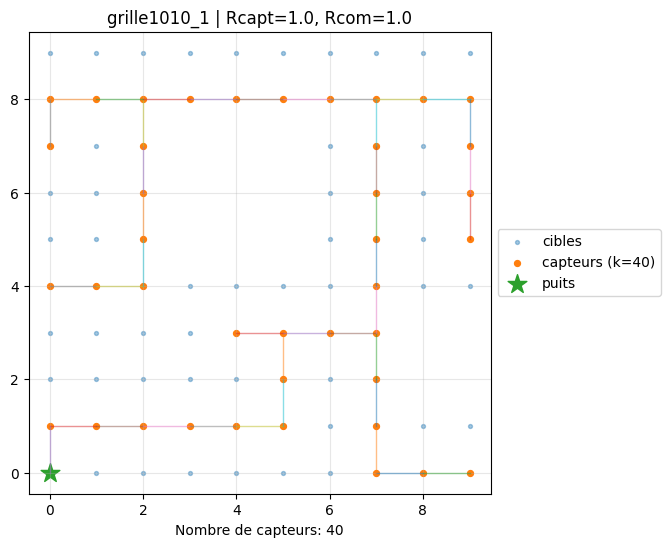

Merge 2->1: Solution trouvée avec 40 capteurs, faisable? True


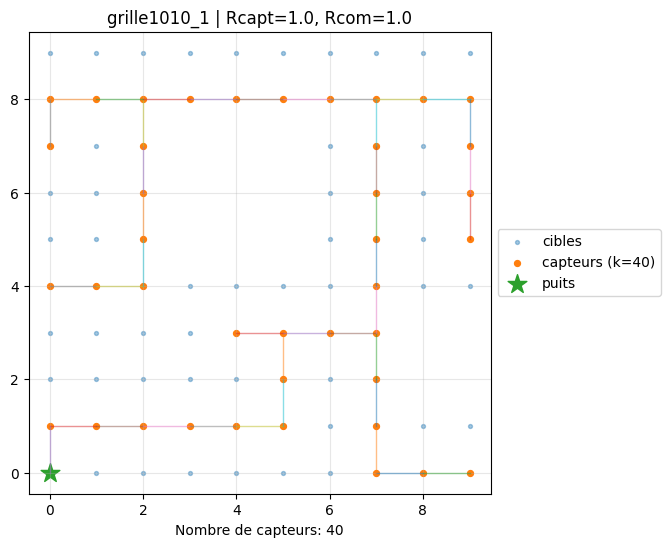

Merge n->1: Solution trouvée avec 40 capteurs, faisable? True


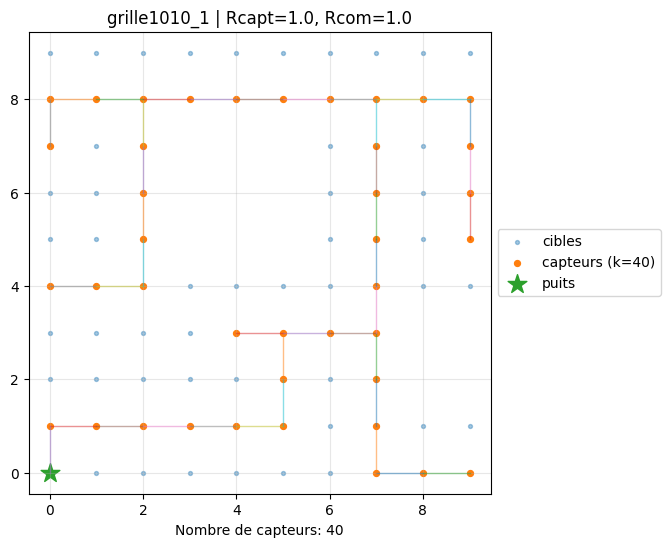

Merge n->1 (après Merge 2->1): Solution trouvée avec 40 capteurs, faisable? True


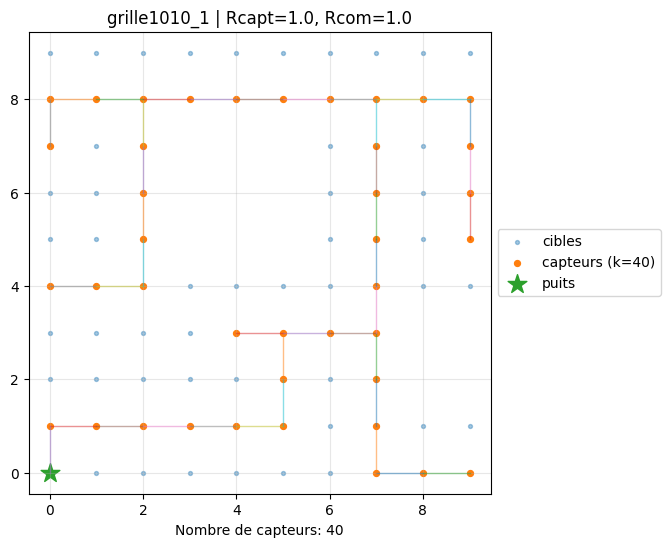

VND: Solution trouvée avec 40 capteurs, faisable? True


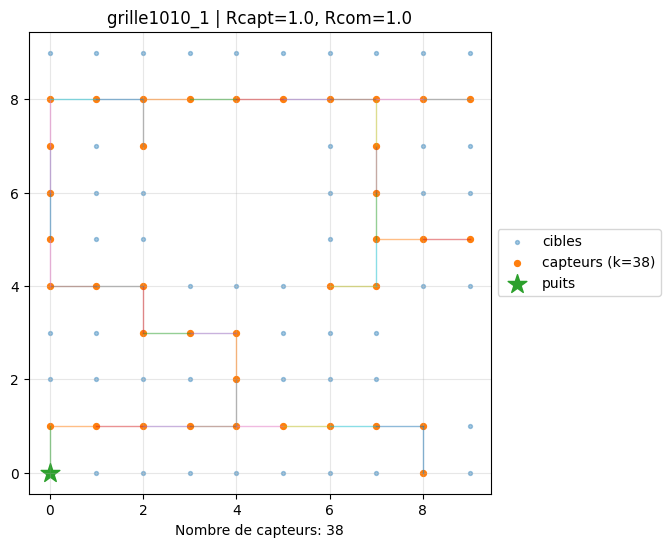

GRASP: Solution trouvée avec 38 capteurs, faisable? True
Taille de la population = 50
Nombre d'individus uniques = 48
Diversité initiale : 96.0%
Algorithme génétique: Solution trouvée avec 40 capteurs, faisable? True


In [185]:
filepath = "C:/Users/Charlène/Documents/ENSTA/3A/Metaheuristique/Projet/Projet de métaheuristiques - Instances grilles tronquées/Projet de métaheuristiques - Instances grilles tronquées/grille1010_1.dat"

instance = load_points_txt(filepath, sink=(0.0, 0.0), name="grille1010_1", truncated=True)
pc = build_precomp(instance, Rcapt=1.0, Rcom=1.0)

# Greedy solution
sol_greedy = greedy_construct(pc)
plot_solution(sol_greedy, pc, show_links=True)
print(f"Greedy: Solution trouvée avec {int(sol_greedy.sum())} capteurs, faisable? {is_feasible(sol_greedy, pc)}")
# Greedy + Repair
sol_repair = repair(sol_greedy, pc)
plot_solution(sol_repair, pc, show_links=True)
print(f"Greedy + Repair: Solution trouvée avec {int(sol_repair.sum())} capteurs, faisable? {is_feasible(sol_repair, pc)}")
# # Merge 2 -> 1
sol_merge2 = merge_2_en_1(sol_repair, pc)
plot_solution(sol_merge2, pc, show_links=True)
print(f"Merge 2->1: Solution trouvée avec {int(sol_merge2.sum())} capteurs, faisable? {is_feasible(sol_merge2, pc)}")
# # Merge n -> 1
sol_mergen = merge_sensors_to_1(sol_repair, pc, max_tuple_size=3)
plot_solution(sol_mergen, pc, show_links=True)
print(f"Merge n->1: Solution trouvée avec {int(sol_mergen.sum())} capteurs, faisable? {is_feasible(sol_mergen, pc)}")

sol_mergen_bis = merge_sensors_to_1(sol_merge2, pc, max_tuple_size=3)
plot_solution(sol_mergen_bis, pc, show_links=True)
print(f"Merge n->1 (après Merge 2->1): Solution trouvée avec {int(sol_mergen_bis.sum())} capteurs, faisable? {is_feasible(sol_mergen_bis, pc)}")
# VND
sol_vnd = vnd(sol_repair, pc, max_neighborhood=3, max_trials=300)
plot_solution(sol_vnd, pc, show_links=True)
print(f"VND: Solution trouvée avec {int(sol_vnd.sum())} capteurs, faisable? {is_feasible(sol_vnd, pc)}")
# GRASP
sol_grasp = grasp(pc, max_iters=50, alpha=0.3, local_search_trials=300)
plot_solution(sol_grasp, pc, show_links=True)
print(f"GRASP: Solution trouvée avec {int(sol_grasp.sum())} capteurs, faisable? {is_feasible(sol_grasp, pc)}")
# Genetic Algorithm
sol_ga = genetic_algorithm(pc, population_size=50, generations=100, mutation_rate=0.1, alpha=0.2)
print(f"Algorithme génétique: Solution trouvée avec {int(sol_ga.sum())} capteurs, faisable? {is_feasible(sol_ga, pc)}")




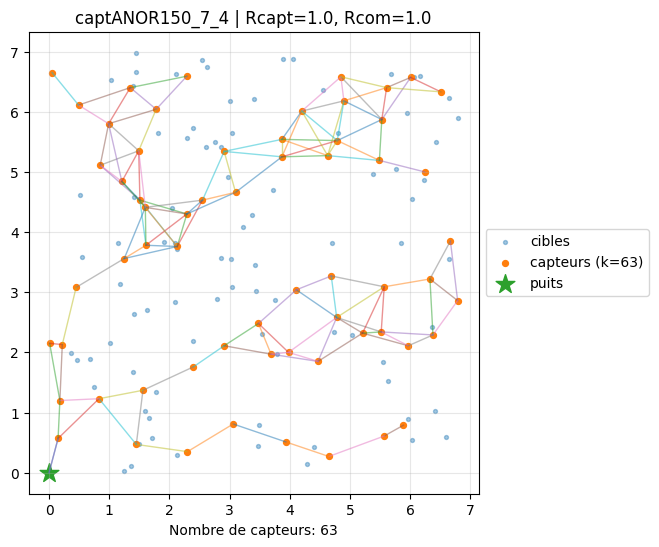

Greedy: Solution trouvée avec 63 capteurs, faisable? True


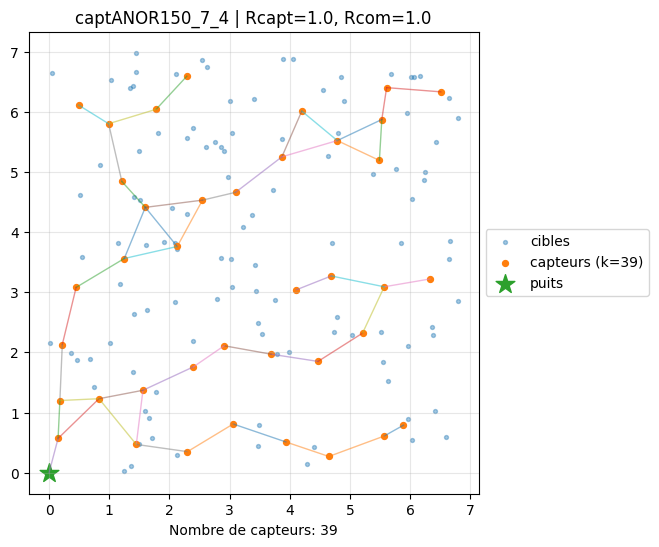

Greedy + Repair: Solution trouvée avec 39 capteurs, faisable? True


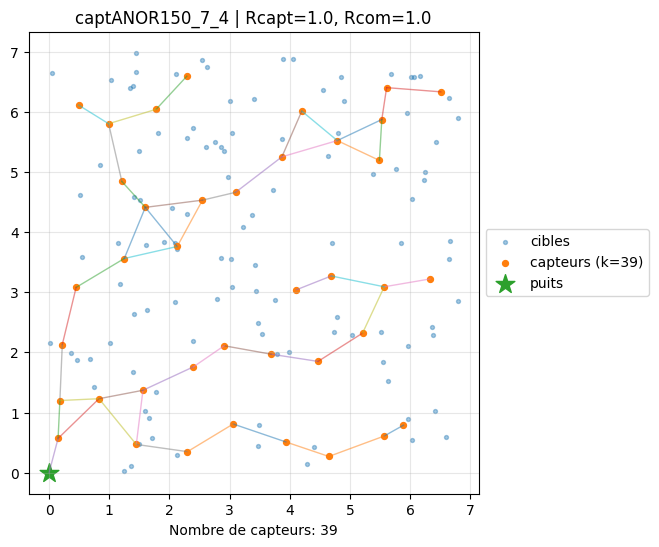

Merge 2->1: Solution trouvée avec 39 capteurs, faisable? True


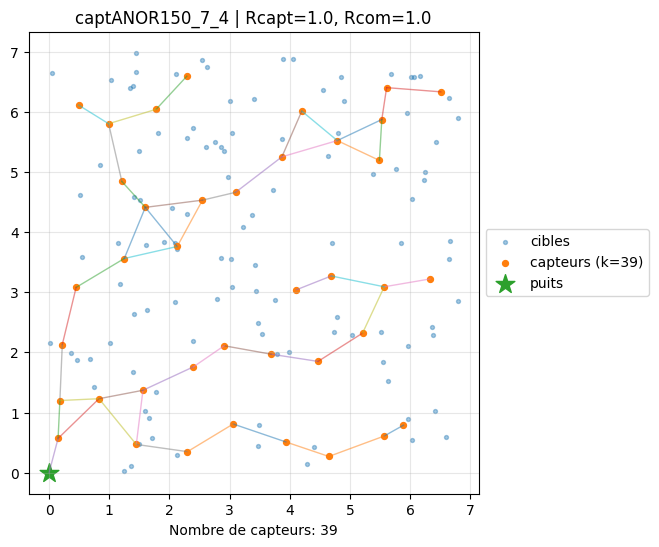

Merge n->1: Solution trouvée avec 39 capteurs, faisable? True


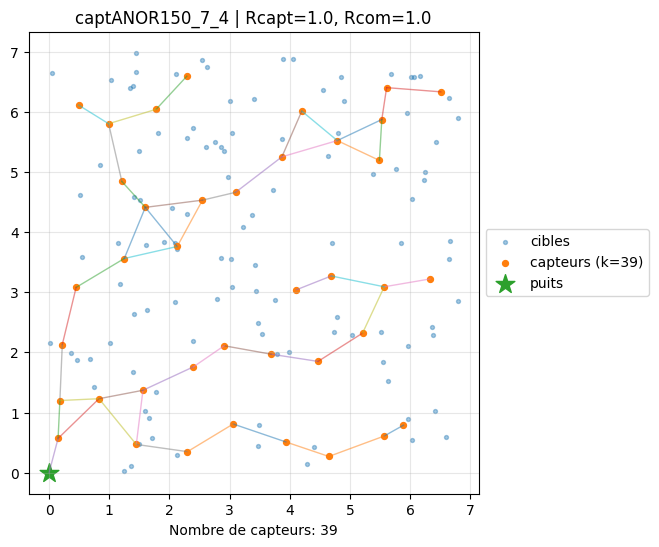

Merge n->1 (après Merge 2->1): Solution trouvée avec 39 capteurs, faisable? True


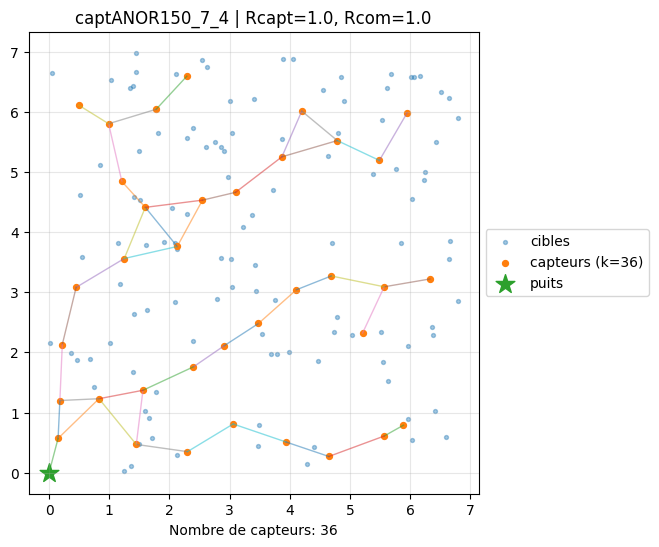

VND: Solution trouvée avec 36 capteurs, faisable? True


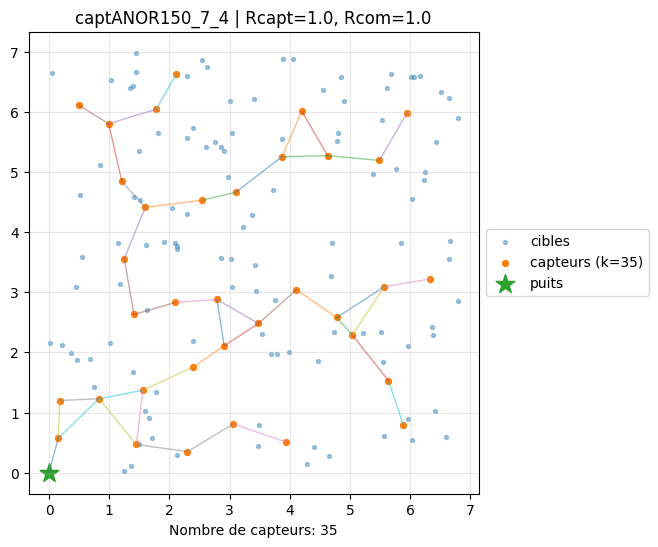

GRASP: Solution trouvée avec 35 capteurs, faisable? True
Taille de la population = 50
Nombre d'individus uniques = 50
Diversité initiale : 100.0%
Algorithme génétique: Solution trouvée avec 35 capteurs, faisable? True


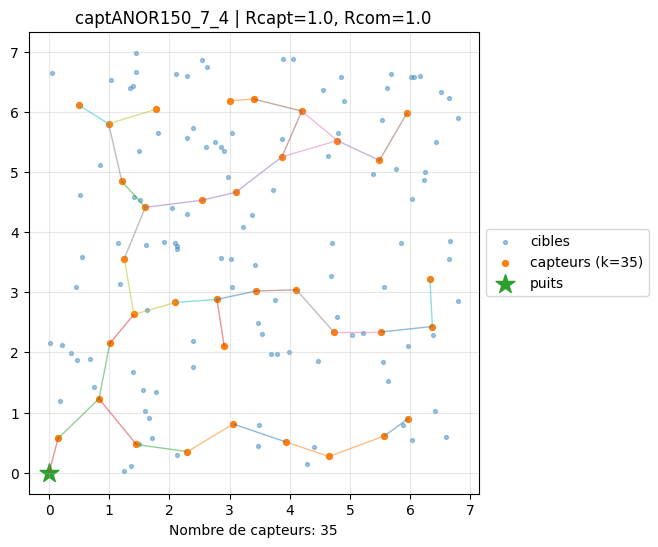

In [187]:
filepath = "C:/Users/Charlène/Documents/ENSTA/3A/Metaheuristique/Projet/Projet de métaheuristiques - Instances cibles générées aléatoirement/Projet de métaheuristiques - Instances cibles générées aléatoirement/captANOR150_7_4.dat"
instance = load_points_txt(filepath, sink=(0.0, 0.0), name="captANOR150_7_4", truncated=False)
pc = build_precomp(instance, Rcapt=1.0, Rcom=1.0)

# Greedy solution
sol_greedy = greedy_construct(pc)
plot_solution(sol_greedy, pc, show_links=True)
print(f"Greedy: Solution trouvée avec {int(sol_greedy.sum())} capteurs, faisable? {is_feasible(sol_greedy, pc)}")
# Greedy + Repair
sol_repair = repair(sol_greedy, pc)
plot_solution(sol_repair, pc, show_links=True)
print(f"Greedy + Repair: Solution trouvée avec {int(sol_repair.sum())} capteurs, faisable? {is_feasible(sol_repair, pc)}")
# # Merge 2 -> 1
sol_merge2 = merge_2_en_1(sol_repair, pc)
plot_solution(sol_merge2, pc, show_links=True)
print(f"Merge 2->1: Solution trouvée avec {int(sol_merge2.sum())} capteurs, faisable? {is_feasible(sol_merge2, pc)}")
# # Merge n -> 1
sol_mergen = merge_sensors_to_1(sol_repair, pc, max_tuple_size=3)
plot_solution(sol_mergen, pc, show_links=True)
print(f"Merge n->1: Solution trouvée avec {int(sol_mergen.sum())} capteurs, faisable? {is_feasible(sol_mergen, pc)}")

sol_mergen_bis = merge_sensors_to_1(sol_merge2, pc, max_tuple_size=3)
plot_solution(sol_mergen_bis, pc, show_links=True)
print(f"Merge n->1 (après Merge 2->1): Solution trouvée avec {int(sol_mergen_bis.sum())} capteurs, faisable? {is_feasible(sol_mergen_bis, pc)}")
# VND
sol_vnd = vnd(sol_repair, pc, max_neighborhood=3, max_trials=300)
plot_solution(sol_vnd, pc, show_links=True)
print(f"VND: Solution trouvée avec {int(sol_vnd.sum())} capteurs, faisable? {is_feasible(sol_vnd, pc)}")
# GRASP
sol_grasp = grasp(pc, max_iters=50, alpha=0.3, local_search_trials=300)
plot_solution(sol_grasp, pc, show_links=True)
print(f"GRASP: Solution trouvée avec {int(sol_grasp.sum())} capteurs, faisable? {is_feasible(sol_grasp, pc)}")
# Genetic Algorithm
sol_ga = genetic_algorithm(pc, population_size=50, generations=100, mutation_rate=0.1, alpha=0.2)
print(f"Algorithme génétique: Solution trouvée avec {int(sol_ga.sum())} capteurs, faisable? {is_feasible(sol_ga, pc)}")
plot_solution(sol_ga, pc, show_links=True)
